In [55]:
from google.colab import drive
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np


drive.mount('/content/drive')
file = open('/content/drive/My Drive/max plank/mpi_saale_2015_2020.csv')
df = pd.read_csv(file)
df = df.drop(len(df)-1)
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Date Time,p (mbar),T (degC),rh (%),sh (g/kg),Tpot (K),Tdew (degC),VPmax (mbar),VPact (mbar),VPdef (mbar),H2OC (mmol/mol),rho (g/m**3),wv (m/s),wd (deg),rain (mm),SWDR (W/m**2)
0,01.07.2015 00:10:04,1005.96,12.98,94.5,8.80,285.65,12.12,14.98,14.15,0.82,14.07,1218.19,0.33,306.20,0.00,0.00
1,01.07.2015 00:20:04,1005.95,12.90,94.8,8.78,285.58,12.09,14.90,14.13,0.77,14.04,1218.53,0.43,145.80,0.00,0.00
2,01.07.2015 00:30:04,1006.01,12.68,94.9,8.66,285.35,11.89,14.69,13.94,0.75,13.85,1219.62,0.29,120.50,0.00,0.00
3,01.07.2015 00:40:04,1006.00,12.57,95.8,8.68,285.24,11.92,14.58,13.97,0.61,13.89,1220.07,0.16,347.40,0.00,0.00
4,01.07.2015 00:50:04,1005.97,12.42,96.2,8.63,285.09,11.83,14.44,13.89,0.55,13.81,1220.71,0.28,28.07,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158790,31.12.2020 23:10:00,988.17,2.19,86.5,3.91,276.28,0.18,7.16,6.19,0.97,6.26,1247.27,1.10,25.82,0.83,-6.82
158791,31.12.2020 23:20:00,988.15,2.16,85.8,3.86,276.25,0.04,7.14,6.13,1.01,6.20,1247.42,1.06,42.76,0.86,-6.53
158792,31.12.2020 23:30:00,988.13,2.15,88.6,3.99,276.24,0.47,7.13,6.32,0.81,6.40,1247.34,0.95,99.60,0.78,-7.59
158793,31.12.2020 23:40:00,988.07,2.03,88.8,3.96,276.13,0.39,7.07,6.28,0.79,6.36,1247.82,0.74,0.00,0.65,-9.78


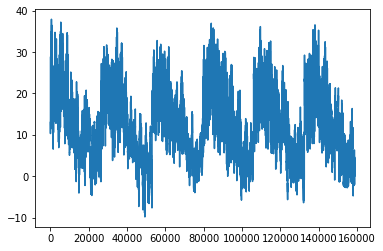

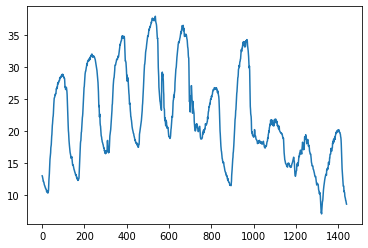

In [56]:
'''데이터 시각화'''

# 온도의 시계열성
temp = df['T (degC)'] # 온도(섭씨) 열
plt.plot(range(len(temp)), temp)
plt.show()

# 10일동안의 시계열성
plt.plot(range(1440), temp[:1440]) # 1440 = (6*24)*10
plt.show()

In [57]:
from sklearn.preprocessing import MinMaxScaler

def ts_train_test(df, time_steps, for_periods):
  # Test[2020년]과 Train[~2019년] 셋 생성
  ts_train = df[:132462].iloc[:,2:3].values
  ts_test = df[132462:].iloc[:,2:3].values
  ts_train_len = len(ts_train)
  ts_test_len = len(ts_test)

  # MinMaxScaler를 이용한 정규화
  sc = MinMaxScaler(feature_range = (0,1))
  ts_train_scaled = sc.fit_transform(ts_train)

  # training 데이터의 samples와 time steps로 원본 데이터 슬라이싱
  X_train = []
  Y_train = []
  Y_train_stacked = []
  for i in range(time_steps, ts_train_len - 1):
    X_train.append(ts_train_scaled[i-time_steps:i,0])
    Y_train.append(ts_train_scaled[i:i+for_periods,0])
  X_train, Y_train = np.array(X_train), np.array(Y_train)

  # X_train -> np.reshape(samples, time steps, features)
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

  inputs = pd.concat((df['T (degC)'][:132462], df['T (degC)'][132462:]), axis = 0).values
  inputs = inputs[len(inputs) - len(ts_test) - time_steps:]
  inputs = inputs.reshape(-1,1)
  inputs = sc.transform(inputs)

  X_test = []
  for i in range(time_steps, ts_test_len + time_steps - for_periods):
    X_test.append(inputs[i - time_steps:i,0])
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

  return X_train, Y_train, X_test, sc

In [58]:
X_train, Y_train, X_test, sc = ts_train_test(df,5,2)

print('There are ' + str(X_train.shape[0]) + ' samples in the training data')
print('There are ' + str(X_test.shape[0]) + ' samples in the test data')

There are 132456 samples in the training data
There are 26331 samples in the test data


In [59]:
from keras.models import Sequential
from keras.layers import Dense, GRU, LSTM

def LSTM_model(X_train, Y_train, X_test, sc):
  my_LSTM_model = Sequential()
  my_LSTM_model.add(LSTM(units = 50,
                         return_sequences = True,
                         input_shape = (X_train.shape[1],1),
                         activation = 'tanh'))
  my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
  my_LSTM_model.add(Dense(units = 2))

  my_LSTM_model.compile(loss = 'mean_squared_error',
                        optimizer = 'adam')
  
  # training data 세트에 fitting
  my_LSTM_model.fit(X_train, Y_train, epochs = 50, batch_size = 150, verbose = 0)
  
  # X_test를 LSTM 모델에 넣어서 예측
  LSTM_prediction = my_LSTM_model.predict(X_test)
  
  # 스케일러에 예측값 넣어서 반환
  LSTM_prediction = sc.inverse_transform(LSTM_prediction)

  return my_LSTM_model, LSTM_prediction

In [60]:
from keras.metrics import MeanSquaredError

def actual_pred_plot(preds):
  actual_pred = pd.DataFrame(columns=['actual', 'prediction'])
  actual_pred['actual'] = df.loc[132463:,'T (degC)'][0:len(preds)]
  actual_pred['prediction'] = preds[:,0]

  m = MeanSquaredError()
  m.update_state(np.array(actual_pred['actual']), np.array(actual_pred['prediction']))

  return (m.result().numpy(), actual_pred.plot())

(0.2998241, <matplotlib.axes._subplots.AxesSubplot at 0x7f812b89ac10>)

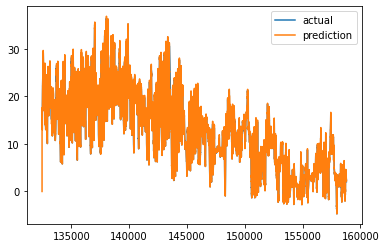

In [61]:
my_LSTM_model, LSTM_prediction = LSTM_model(X_train, Y_train, X_test, sc)
actual_pred_plot(LSTM_prediction)

In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def confirm_result(Y_test, Y_pred):
  MAE = mean_absolute_error(Y_test, Y_pred)
  RMSE = np.sqrt(mean_squared_error(Y_test, Y_pred))
  R2 = r2_score(Y_test,Y_pred)

  pd.options.display.float_format = '{:.5f}'.format
  Result = pd.DataFrame(data = [MAE, RMSE, R2],
                        index = ['MAE', 'RMSE', 'R2'],
                        columns = ['Result'])
  
  return Result

In [62]:
Y_pred = pd.DataFrame(LSTM_prediction[:,0])
Y_test = df.loc[132463:,'T (degC)'][0:len(LSTM_prediction)]
Y_test.reset_index(drop = True, inplace = True)

In [64]:
confirm_result(Y_test, Y_pred)

,Result
MAE,0.34760
RMSE,0.54756
R2,0.99535


In [65]:
def GRU_model(X_train, Y_train, X_test, sc):
  my_GRU_model = Sequential()
  my_GRU_model.add(GRU(units = 50,
                         return_sequences = True,
                         input_shape = (X_train.shape[1],1),
                         activation = 'tanh'))
  my_GRU_model.add(GRU(units = 50, activation = 'tanh'))
  my_GRU_model.add(Dense(units = 2))

  my_GRU_model.compile(loss = 'mean_squared_error',
                        optimizer = 'adam')
  
  # training data 세트에 fitting
  my_GRU_model.fit(X_train, Y_train, epochs = 50, batch_size = 150, verbose = 0)
  
  # X_test를 LSTM 모델에 넣어서 예측
  GRU_prediction = my_GRU_model.predict(X_test)
  
  # 스케일러에 예측값 넣어서 반환
  GRU_prediction = sc.inverse_transform(GRU_prediction)

  return my_GRU_model, GRU_prediction

(0.31138662, <matplotlib.axes._subplots.AxesSubplot at 0x7f8133f2c8d0>)

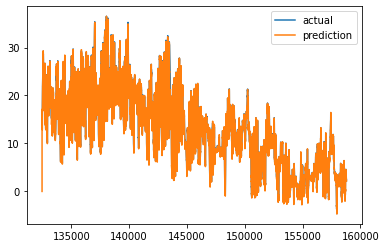

In [66]:
# 실제 기온 데이터[2020년]과 예측값 그래프 비교
my_GRU_model, GRU_prediction = GRU_model(X_train, Y_train, X_test, sc)
actual_pred_plot(GRU_prediction)

In [68]:
Y_pred_gru = pd.DataFrame(GRU_prediction[:, 0])
Y_test_gru = df.loc[132463:,'T (degC)'][0:len(GRU_prediction)]
Y_test_gru.reset_index(drop=True, inplace = True)

In [69]:
confirm_result(Y_test_gru, Y_pred_gru)

,Result
MAE,0.35610
RMSE,0.55802
R2,0.99517
